# Libraries used:

numpy 1.19.5
<br>
tensorflow 2.4.1
<br>
pandas 1.2.4
<br>
matplotlib 3.3.4
<br>
tensorflow_addons 0.12.1 

In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [2]:
tf.random.set_seed(1234)

# Data processing and augmentation

In [3]:
df=pd.read_csv('Train.csv')
df.head(5)

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [4]:
fnames=[]
classes=[]
bbox=[]
for i in range(len(df)):
    fnames.append('Train_Images\\{}.jpg'.format(df['Image_ID'][i]))
    
    label_name=df['class'][i]
    if label_name=='fruit_healthy':
        labels=np.array([1,0,0])
    if label_name=='fruit_woodiness':
        labels=np.array([0,1,0])
    if label_name=='fruit_brownspot':
        labels=np.array([0,0,1])
    classes.append(labels)    
    
    bbox_coordinates=np.array([df['xmin'][i]+0.5*df['width'][i],df['ymin'][i]+0.5*df['height'][i],
                               df['width'][i],df['height'][i]])
    bbox.append(bbox_coordinates.astype('float32'))
    

In [5]:
#add multiple bounding boxes to same image (placeholder for 5 bounding boxes)

fname_p=fnames[0]
multiple_classes=[classes[0]]
multiple_bbox=[bbox[0]]

fnames_sorted=[]
classes_sorted=[]
bbox_sorted=[]

for i in range(1,len(fnames)):
    fname_i=fnames[i]
    class_i=classes[i]
    bbox_i=bbox[i]
    if fname_i!=fname_p:
        while len(multiple_classes)!=5:
            multiple_classes.append(np.array([0,0,0]))
            multiple_bbox.append(np.array([0,0,1,1],dtype='float32'))
        fnames_sorted.append(fname_p)
        classes_sorted.append(multiple_classes)
        bbox_sorted.append(multiple_bbox)
        multiple_classes=[]
        multiple_bbox=[]
        fname_p=fname_i
        
    multiple_classes.append(class_i)
    multiple_bbox.append(bbox_i)
    
    


In [6]:
ds_size=len(fnames_sorted)

fnames_dataset = tf.data.Dataset.from_tensor_slices(fnames_sorted)
classes_dataset = tf.data.Dataset.from_tensor_slices(classes_sorted)
bbox_dataset = tf.data.Dataset.from_tensor_slices(bbox_sorted)

ds = tf.data.Dataset.zip((fnames_dataset, classes_dataset, bbox_dataset))

In [7]:
train_ratio = 0.80
ds_train1=ds.take(int(ds_size*train_ratio))
ds_test1=ds.skip(int(ds_size*train_ratio))

Augmentation: rotate images and bounding boxes by 90, 180 and 270 degrees

In [8]:
def bbox_rotation(bbox,deg):
    bbox=bbox.numpy()
    #deg 1: 90, 2:180, 3: 270
    if deg==0:
        return tf.constant(bbox)
    if deg==3:
        return tf.constant([[512-bbox[0,1],bbox[0,0],bbox[0,3],bbox[0,2]],
                           [512-bbox[1,1],bbox[1,0],bbox[1,3],bbox[1,2]],
                           [512-bbox[2,1],bbox[2,0],bbox[2,3],bbox[2,2]],
                           [512-bbox[3,1],bbox[3,0],bbox[3,3],bbox[3,2]],
                           [512-bbox[4,1],bbox[4,0],bbox[4,3],bbox[4,2]]],dtype='float32')
    
    elif deg==2:
        return tf.constant([[512-bbox[0,0],512-bbox[0,1],bbox[0,2],bbox[0,3]],
                           [512-bbox[1,0],512-bbox[1,1],bbox[1,2],bbox[1,3]],
                           [512-bbox[2,0],512-bbox[2,1],bbox[2,2],bbox[2,3]],
                           [512-bbox[3,0],512-bbox[3,1],bbox[3,2],bbox[3,3]],
                           [512-bbox[4,0],512-bbox[4,1],bbox[4,2],bbox[4,3]]],dtype='float32')

    elif deg==1:
        return tf.constant([[bbox[0,1],512-bbox[0,0],bbox[0,3],bbox[0,2]],
                           [bbox[1,1],512-bbox[1,0],bbox[1,3],bbox[1,2]],
                           [bbox[2,1],512-bbox[2,0],bbox[2,3],bbox[2,2]],
                           [bbox[3,1],512-bbox[3,0],bbox[3,3],bbox[3,2]],
                           [bbox[4,1],512-bbox[4,0],bbox[4,3],bbox[4,2]]],dtype='float32')
    else:
        return NotImplemented



IMG_SIZE=512
def process_img(img, deg):
    image = tf.io.read_file(img)
    image = tf.image.decode_jpeg(image, channels=3) 
    image = tf.image.convert_image_dtype(image, tf.float32) 
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image=tfa.image.rotate(image,tf.constant(np.pi*0.5*deg))
    return image

def read_images(fnames, classes, bbox, deg):
    img = process_img(fnames, deg)
    bbox=bbox_rotation(bbox,deg)
    return img, classes, bbox

In [9]:
ds_train=ds_train1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 0.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_train_rotate1=ds_train1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 1.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_train_rotate2=ds_train1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 2.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_train_rotate3=ds_train1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 3.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)


ds_train=ds_train.concatenate(ds_train_rotate1)
ds_train=ds_train.concatenate(ds_train_rotate2)
ds_train=ds_train.concatenate(ds_train_rotate3)

ds_test=ds_test1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 0.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_test_rotate1=ds_test1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 1.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_test_rotate2=ds_test1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 2.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_test_rotate3=ds_test1.map(lambda img, classes, bbox: tf.py_function(func=read_images,
          inp=[img, classes, bbox, 3.], Tout=(tf.float32,tf.int32,tf.float32)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=True)

ds_test=ds_test.concatenate(ds_test_rotate1)
ds_test=ds_test.concatenate(ds_test_rotate2)
ds_test=ds_test.concatenate(ds_test_rotate3)

## Anchors

In [10]:
width=np.array(df['width'][:])
height=np.array(df['height'][:])

height_width_ratio=height/width
area=height*width

std_weight_ar=1
std_weight_area=1.5

aspect_ratios=np.array([1/(1-std_weight_ar*np.std(height_width_ratio)),
                        1,
                       (1-std_weight_ar*np.std(height_width_ratio))])
areas=np.array([(np.mean(height)-std_weight_area*np.std(height))**2,
                np.mean(height)**2,
                       (np.mean(height)+std_weight_area*np.std(height))**2])



print('hw_ratio:')
print(aspect_ratios)
print('area:')
print(areas)

area_aspect_ratio_combination=[]
for area in areas:
    for aspect_ratio in aspect_ratios:
        area_aspect_ratio_combination.append(np.array([area,aspect_ratio]))
        
width_height_combination=[]
for area, aspect_ratio in area_aspect_ratio_combination:
    width=(area/aspect_ratio)**0.5
    height=area/width
    width_height_combination.append(np.array([width,height]))

stride=32
nr_seg=(int(IMG_SIZE/stride))

x_centres=np.arange(stride/2,IMG_SIZE,stride)
y_centres=np.arange(stride/2,IMG_SIZE,stride)
xx, yy = np.meshgrid(x_centres, y_centres, sparse=False, indexing='xy')

print('Anchors width-height combinations')
print(width_height_combination)

hw_ratio:
[1.68218021 1.         0.59446663]
area:
[10505.79826832 41160.3691945  91968.18773159]
Anchors width-height combinations
[array([ 79.02750468, 132.93850427]), array([102.49779641, 102.49779641]), array([132.93850427,  79.02750468]), array([156.42399425, 263.13334722]), array([202.88018433, 202.88018433]), array([263.13334722, 156.42399425]), array([233.82048383, 393.32819018]), array([303.26257226, 303.26257226]), array([393.32819018, 233.82048383])]


In [11]:
reg_anchors=np.zeros((nr_seg,nr_seg,9,4))
nr_anchors=nr_seg*nr_seg*9

for y_index in range(nr_seg):
    for x_index in range(nr_seg):
        for anchor_index in range(9):
            #x_centre
            reg_anchors[y_index,x_index,anchor_index,0]=xx[y_index,x_index]
            #y_centre
            reg_anchors[y_index,x_index,anchor_index,1]=yy[y_index,x_index]
            #width
            reg_anchors[y_index,x_index,anchor_index,2]=width_height_combination[anchor_index][0]
            #height
            reg_anchors[y_index,x_index,anchor_index,3]=width_height_combination[anchor_index][1]
            

x_a=reg_anchors[:, :, :, 0]
y_a=reg_anchors[:, :, :, 1]
w_a=reg_anchors[:, :, :, 2]
h_a=reg_anchors[:, :, :, 3]            

reg_anchors_tf_overlap=tf.convert_to_tensor(reg_anchors,dtype='float32')
reg_anchors_tf_overlap=tf.reshape(reg_anchors_tf_overlap, [nr_seg*nr_seg*9, 4])

training_anchors=np.ones((nr_seg,nr_seg,9))

for y_index in range(nr_seg):
    for x_index in range(nr_seg):
        for anchor_index in range(9):
            #check for anchor boxes with boundaries outside

            if (x_a[y_index,x_index,anchor_index]-0.5*w_a[y_index,x_index,anchor_index]<0 or
                x_a[y_index,x_index,anchor_index]+0.5*w_a[y_index,x_index,anchor_index]>IMG_SIZE or
                y_a[y_index,x_index,anchor_index]-0.5*h_a[y_index,x_index,anchor_index]<0 or
                y_a[y_index,x_index,anchor_index]+0.5*h_a[y_index,x_index,anchor_index]>IMG_SIZE):
                training_anchors[y_index,x_index,anchor_index]=False
            else: 
                training_anchors[y_index,x_index,anchor_index]=True

training_anchors_tf=tf.convert_to_tensor(training_anchors)
training_anchors_tf=tf.reshape(training_anchors_tf, [nr_seg*nr_seg*9])

reg_anchors_tf=tf.boolean_mask(
    reg_anchors_tf_overlap, training_anchors_tf, axis=None, name='boolean_mask'
)

Anchors visualization

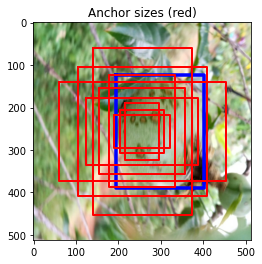

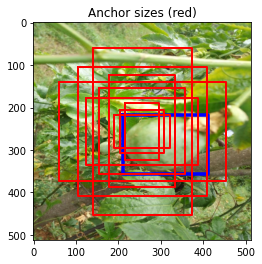

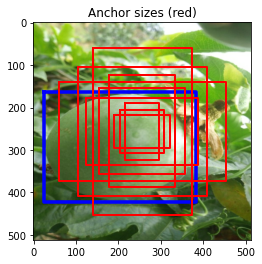

In [12]:
a=ds_test_rotate3.take(3)

for img, classes, bbox in a:
    plt.figure()
    plt.imshow(img.numpy())
    for i in range(5):
        if sum(classes[i])!=0:
            bbox_x=[bbox[i][0]-0.5*bbox[i][2],bbox[i][0]+0.5*bbox[i][2],
                bbox[i][0]+0.5*bbox[i][2],bbox[i][0]-0.5*bbox[i][2],
               bbox[i][0]-0.5*bbox[i][2]]
            bbox_y=[bbox[i][1]-0.5*bbox[i][3],bbox[i][1]-0.5*bbox[i][3],
                    bbox[i][1]+0.5*bbox[i][3],bbox[i][1]+0.5*bbox[i][3],
                   bbox[i][1]-0.5*bbox[i][3]]
            bbox_x=[bbox_x[i]*(IMG_SIZE/512) for i in range(len(bbox_x))]
            bbox_y=[bbox_y[i]*(IMG_SIZE/512) for i in range(len(bbox_y))]
            plt.plot(bbox_x,bbox_y,'b-',linewidth=3.5)
            
    plt.title('Anchor sizes (red)')
    
    centre=512/2
    for i in range(9):
        w=width_height_combination[i][0]
        h=width_height_combination[i][1]
        bbox_x=[centre-0.5*w,centre+0.5*w,
                centre+0.5*w,centre-0.5*w,
               centre-0.5*w]
        bbox_y=[centre-0.5*h,centre-0.5*h,
                centre+0.5*h,centre+0.5*h,
               centre-0.5*h]
        plt.plot(bbox_x,bbox_y,'r-',linewidth=2)
        

In [13]:
ds_train_final = ds_train.map(lambda a, b, c: (a, (b,c)))
ds_test_final = ds_test.map(lambda a, b, c: (a, (b,c)))

# Model building

In [14]:
@tf.function
def calc_reg_targets(bboxes):
    bboxes=tf.tile(tf.expand_dims(bboxes,axis=1),tf.stack([1,tf.shape(reg_anchors_tf)[0],1]))
    targets=[]
    
    t_x_star=(bboxes[:,:,0]-reg_anchors_tf[:,0])/reg_anchors_tf[:,2]
    t_y_star=(bboxes[:,:,1]-reg_anchors_tf[:,1])/reg_anchors_tf[:,3]
    t_w_star=tf.math.log(bboxes[:,:,2]/reg_anchors_tf[:,2])
    t_h_star=tf.math.log(bboxes[:,:,3]/reg_anchors_tf[:,3])

    target=tf.stack([t_x_star,t_y_star,t_w_star,t_h_star],axis=-1)

    return target

@tf.function
def IoU(inputs):
    anchor=inputs[:4]
    target=inputs[4:]
    gl = tfa.losses.GIoULoss(mode = 'iou')
    
    boxes1 = tf.stack([anchor[1]-0.5*anchor[3], anchor[0]-0.5*anchor[2], 
                          anchor[1]+0.5*anchor[3], anchor[0]+0.5*anchor[2]],axis=0)
    boxes2 = tf.stack([target[1]-0.5*target[3], target[0]-0.5*target[2], 
                          target[1]+0.5*target[3], target[0]+0.5*target[2]],axis=0)
    loss = gl(boxes1, boxes2)
    return 1-loss


@tf.function
def IoU_matrix(bboxes):
    bboxes_tile=tf.tile(bboxes,tf.stack([tf.shape(reg_anchors_tf)[0],1]))
    

    reg_anchors_tf_tile=tf.tile(reg_anchors_tf,tf.stack([tf.shape(bboxes)[0],1]))
    
    inputs=tf.concat([reg_anchors_tf_tile,bboxes_tile],axis=-1)
    
    ans=tf.map_fn(IoU, inputs) 
    
    ans_reshape=tf.reshape(ans,(tf.shape(bboxes)[0],tf.shape(reg_anchors_tf)[0]))
    
    return ans_reshape

@tf.function
def cls_score(IoU_matrix):
    score = tf.ones_like(IoU_matrix)*(-1)

    max_array = tf.tile(tf.expand_dims(tf.math.reduce_max(IoU_matrix, axis=1),axis=-1),
            tf.stack([1,tf.shape(IoU_matrix)[-1]]))

    score = tf.where(max_array==IoU_matrix,1.,score)
    IoU_matrix = tf.where(max_array==IoU_matrix,1.,IoU_matrix)
    

    score = tf.where(IoU_matrix>0.7, 1., score)  
    score = tf.where(IoU_matrix<0.1, 0., score)
    
    return score

@tf.function
def train_sampling(score,possible_targets,seed):
    positive_indexes=tf.where(score==1)
    negative_indexes=tf.where(score==0)
    
    nr_samples_positive=tf.math.minimum(tf.shape(positive_indexes)[0],128)
    
    idxs_p = tf.range(tf.shape(positive_indexes)[0])
    ridxs_p = tf.random.shuffle(idxs_p,seed=seed)[:nr_samples_positive]
    positive_indexes_sampled = tf.gather(positive_indexes, ridxs_p)
    
    idxs_n = tf.range(tf.shape(negative_indexes)[0])
    ridxs_n = tf.random.shuffle(idxs_n,seed=seed)[:nr_samples_positive]
    negative_indexes_sampled = tf.gather(negative_indexes, ridxs_n)
    
    positive_score=tf.gather_nd(score, positive_indexes_sampled)
    negative_score=tf.gather_nd(score, negative_indexes_sampled)
    
    final_score=tf.concat([positive_score,negative_score],axis=0)
    
    positive_targets=tf.gather_nd(possible_targets, positive_indexes_sampled)
    negative_targets=tf.gather_nd(possible_targets, negative_indexes_sampled)
    
    final_targets=tf.concat([positive_targets,negative_targets],axis=0)
    
    indexes_sampled=tf.concat([positive_indexes_sampled,negative_indexes_sampled],axis=0)
    
    return final_score, final_targets,indexes_sampled[:,1]

@tf.function
def smooth_L1(x):
    ans=tf.where(tf.abs(x)<1,0.5*x**2,tf.abs(x)-0.5)
    return tf.reduce_sum(ans)
        

@tf.function
def RPN_training_loss(score_pred,target_pred, final_score, final_targets, indexes_sampled):
    positive_indexes=tf.where(final_score==1)
    
    number_of_targets=tf.cast(tf.shape(final_targets)[-2], dtype='int32')
    
    final_score_2=tf.expand_dims(final_score,axis=-1)
    final_score_2=tf.concat([final_score_2,1-final_score_2],axis=1)
    
    indexes_sampled_output=tf.gather(tf.where(training_anchors_tf),indexes_sampled, axis=-2)
    indexes_sampled_output=tf.squeeze(indexes_sampled_output, axis=-1)

    
    score_pred=tf.gather(score_pred,indexes_sampled_output, axis=-2)
    target_pred=tf.gather(target_pred,indexes_sampled_output, axis=-2)
    
    score_pred=tf.squeeze(score_pred,axis=0)
    target_pred=tf.squeeze(target_pred,axis=0)
    
    cce = tf.keras.losses.CategoricalCrossentropy()
    class_loss_mean=cce(final_score_2, score_pred)
    
    reg_loss_total=tf.reduce_sum(tf.math.multiply(final_score,
                                            tf.map_fn(smooth_L1, (target_pred-final_targets))))
    
    reg_loss_mean=tf.divide(reg_loss_total,tf.cast(number_of_targets, dtype='float32'))
    
    return (class_loss_mean+reg_loss_mean)*tf.cast(number_of_targets, dtype='float32')
    

## Region proposal network

In [15]:
class RPN(tf.keras.models.Model):
    def __init__(self):
        super(RPN, self).__init__()
                 

        self.base_model = tf.keras.applications.VGG16(
                weights='imagenet',  
                input_shape=(IMG_SIZE, IMG_SIZE, 3), 
                include_top=False)  
        #self.base_model.trainable=False
        for i in range(14):
            self.base_model.layers[i].trainable=False
        
        self.conv1=tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same')

        self.box_reg=tf.keras.layers.Conv2D(36, (1,1), activation='relu')
        self.box_reg_reshape=tf.keras.layers.Reshape((nr_seg, nr_seg, 9, 4))

        self.box_cls=tf.keras.layers.Conv2D(18, (1,1), activation='relu')
        self.box_cls_reshape=tf.keras.layers.Reshape((nr_seg, nr_seg, 9, 2))

        self.concat1=tf.keras.layers.Concatenate(axis=-1)
        self.reshape_final=tf.keras.layers.Reshape((nr_seg*nr_seg*9, 6))
        
        
    def call(self, image):
        image = tf.reshape(image, (1, tf.shape(image)[-3], tf.shape(image)[-2], tf.shape(image)[-1])) #Line 4
        image=tf.reverse(image, axis=[-1])
        image=tf.image.per_image_standardization(image)
        
        x = self.base_model(image, training=False)
        conv1= self.conv1(x)
        
        box_reg1=self.box_reg(conv1)
        box_reg_reshape1=self.box_reg_reshape(box_reg1)
        
        box_cls1=self.box_cls(conv1)
        box_cls_reshape1=self.box_cls_reshape(box_cls1)
        box_cls_reshape1_softmax=tf.keras.activations.softmax(box_cls_reshape1)
        
        concat1=self.concat1([box_cls_reshape1_softmax, box_reg_reshape1])
        reshape1=self.reshape_final(concat1)
        
        return reshape1

    
    #@tf.function
    def train_step(self, data):
        
        inputs= data[0]
        targets= data[1]
        
        classes=targets[0]
        bbox=targets[1]
        number_of_bbox=tf.reduce_sum(classes)
        number_of_bbox=tf.cast(number_of_bbox, dtype='int32')
        
        classes=classes[:number_of_bbox,:]
        bbox=bbox[:number_of_bbox,:]
        
        possible_targets1=calc_reg_targets(bbox)
        
        IoU_matrix1=IoU_matrix(bbox)
        
        score1=cls_score(IoU_matrix1)
        
        final_score1, final_targets1, indexes_sampled1=train_sampling(score1,possible_targets1,seed=0)

        with tf.GradientTape() as tape:
            y_pred = self(inputs)
            score_pred1, target_pred1 = tf.split(y_pred, [2, 4], -1)
            
            loss_value = RPN_training_loss(score_pred1, target_pred1, 
                                           final_score1, final_targets1, indexes_sampled1)
            
            

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"loss_value": loss_value}
    
    @tf.function
    def bbox_predictions(self, inputs):
        y_pred = self(inputs)
        indexes_sampled_output=tf.squeeze(tf.where(training_anchors_tf),axis=-1)
        
        y_pred = tf.gather(y_pred,indexes_sampled_output, axis=-2)

        
        score_pred1, target_pred1 = tf.split(y_pred, [2, 4], -1)
        
        scores=score_pred1[:,:,0]
        
        
        t_x=target_pred1[:,:,0]
        t_y=target_pred1[:,:,1]
        t_w=target_pred1[:,:,2]
        t_h=target_pred1[:,:,3]
        
        x=t_x*reg_anchors_tf[:,2]+reg_anchors_tf[:,0]
        y=t_y*reg_anchors_tf[:,3]+reg_anchors_tf[:,1]
        w=tf.math.exp(t_w)*reg_anchors_tf[:,2]
        h=tf.math.exp(t_h)*reg_anchors_tf[:,3]
        
        bbox_pred=tf.stack([x,y,w,h], axis=-1)
        bbox_non_max_suppression=tf.stack([y-0.5*h,x-0.5*w,y+0.5*h,x+0.5*w], axis=-1)#[y1,x1,y2,x2]
        
        sorted_indexes=tf.argsort(tf.squeeze(scores,axis=0), axis=-1, direction='DESCENDING')
        
        bbox_pred_sorted=tf.gather(bbox_pred,sorted_indexes, axis=-2)
        scores_sorted=tf.gather(scores,sorted_indexes, axis=-1)
        bbox_non_max_suppression_sorted=tf.gather(bbox_non_max_suppression,sorted_indexes, axis=-2)
        
        bbox_pred_sorted=tf.squeeze(bbox_pred_sorted,axis=0)
        scores_sorted=tf.squeeze(scores_sorted,axis=0)
        bbox_non_max_suppression_sorted=tf.squeeze(bbox_non_max_suppression_sorted,axis=0)
        
        final_indexes=tf.image.non_max_suppression(
            bbox_non_max_suppression_sorted, scores_sorted, max_output_size=10, iou_threshold=0.4,
            score_threshold=0.4
        )
        
        bbox_pred_final=tf.gather(bbox_pred_sorted,final_indexes, axis=-2)
        scores_final=tf.gather(scores_sorted,final_indexes, axis=-1)
        
        return scores_final, bbox_pred_final
        

In [16]:
rpn1=RPN()
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
rpn1(inputs)
rpn1.summary()
rpn1.base_model.summary()

Model: "rpn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
conv2d (Conv2D)              multiple                  2359808   
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  18468     
_________________________________________________________________
reshape (Reshape)            multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  9234      
_________________________________________________________________
reshape_1 (Reshape)          multiple                  0         
_________________________________________________________________
concatenate (Concatenate)    multiple                  0       

# Training:
To train the RPN, uncomment the following block. This will reproduce and save the weight files in the 'checkpoints' folder. If the cell is not run, the weights will be loaded from the 'checkpoints' folder.

In [17]:
# rpn1=RPN()
# rpn1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=None)

# rpn1.fit(x=ds_train_final, batch_size=1, shuffle=True, epochs=2)

# rpn1.save_weights('./checkpoints/RPN_9600_mini_batches_adam_0.0001_scaled_loss_standardized_epoch2')

In [18]:
rpn1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=None)

rpn1.load_weights('./checkpoints/RPN_9600_mini_batches_adam_0.0001_scaled_loss_standardized_epoch2') 

# Visualization of region proposals

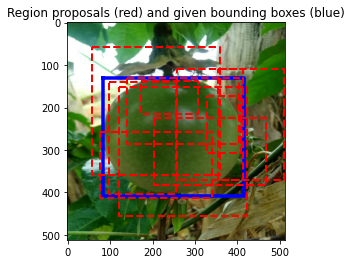

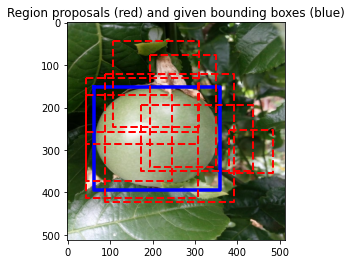

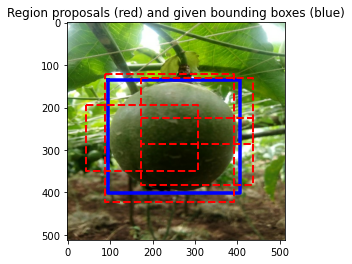

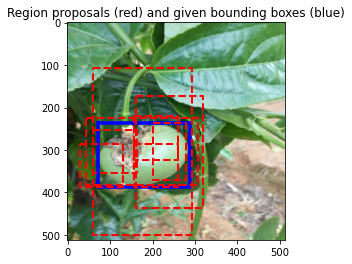

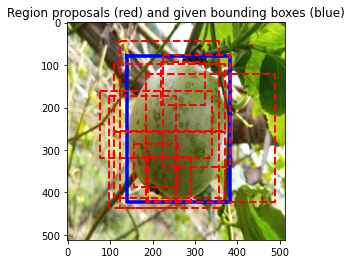

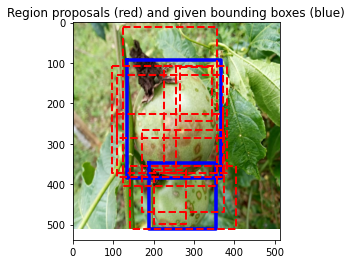

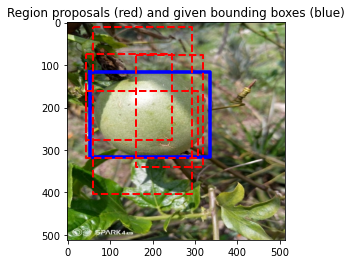

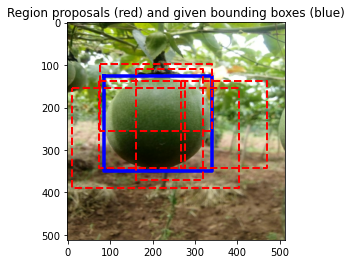

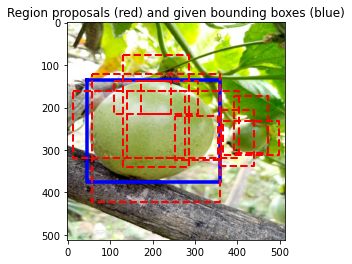

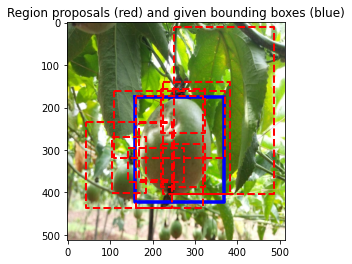

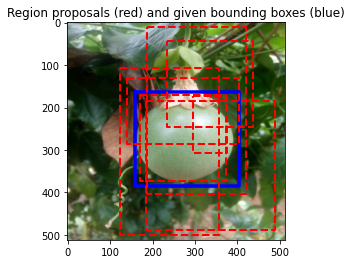

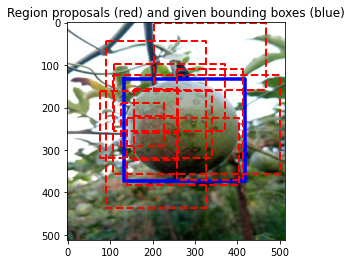

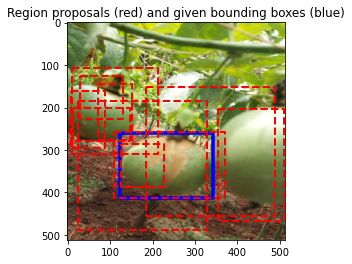

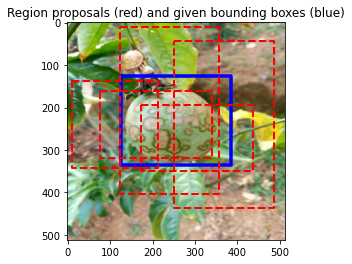

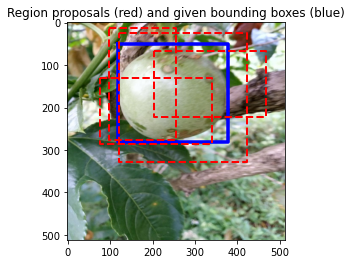

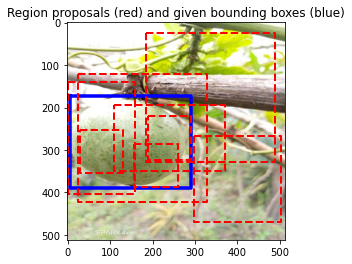

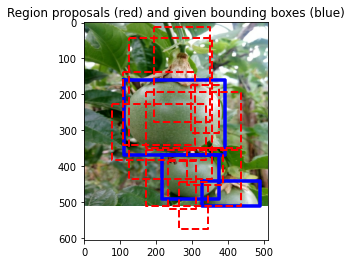

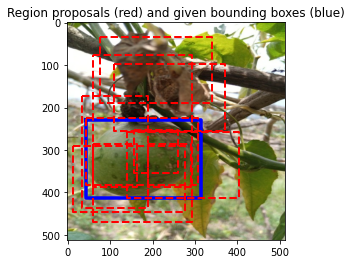

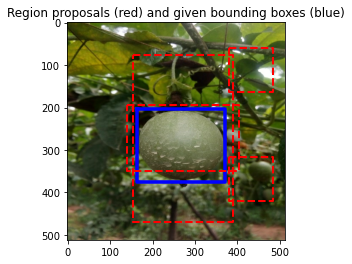

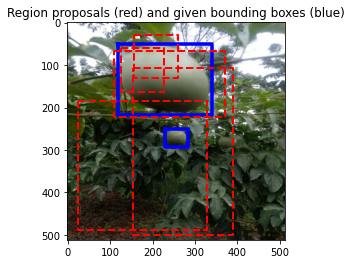

In [19]:
ds_i=ds_test_final.take(40).skip(20)

for img, targets in ds_i:
    img=tf.expand_dims(img,axis=0)
    classes,bbox_targets=targets
    
    #print(bbox_targets)
    plt.figure()
    plt.imshow(np.squeeze(img.numpy()))
    #plt.show()
    title=[]
    
    for i in range(5):
        if sum(classes[i])!=0:
            bbox_x=[bbox_targets[i,0]-0.5*bbox_targets[i,2],bbox_targets[i,0]+0.5*bbox_targets[i,2],
                bbox_targets[i,0]+0.5*bbox_targets[i,2],bbox_targets[i,0]-0.5*bbox_targets[i,2],
               bbox_targets[i,0]-0.5*bbox_targets[i,2]]
            bbox_y=[bbox_targets[i,1]-0.5*bbox_targets[i,3],bbox_targets[i,1]-0.5*bbox_targets[i,3],
                    bbox_targets[i,1]+0.5*bbox_targets[i,3],bbox_targets[i,1]+0.5*bbox_targets[i,3],
                   bbox_targets[i,1]-0.5*bbox_targets[i,3]]
            bbox_x=[bbox_x[i]*(IMG_SIZE/512) for i in range(len(bbox_x))]
            bbox_y=[bbox_y[i]*(IMG_SIZE/512) for i in range(len(bbox_y))]
            plt.plot(bbox_x,bbox_y,'b-',linewidth=3.5)
    
    score, bbox=rpn1.bbox_predictions(img)
    
    
    for i in range(score.shape[0]):
        bbox_x=[bbox[i,0]-0.5*bbox[i,2],bbox[i,0]+0.5*bbox[i,2],
            bbox[i,0]+0.5*bbox[i,2],bbox[i,0]-0.5*bbox[i,2],
           bbox[i,0]-0.5*bbox[i,2]]
        bbox_y=[bbox[i,1]-0.5*bbox[i,3],bbox[i,1]-0.5*bbox[i,3],
                bbox[i,1]+0.5*bbox[i,3],bbox[i,1]+0.5*bbox[i,3],
               bbox[i,1]-0.5*bbox[i,3]]
        bbox_x=[bbox_x[i]*(IMG_SIZE/512) for i in range(len(bbox_x))]
        bbox_y=[bbox_y[i]*(IMG_SIZE/512) for i in range(len(bbox_y))]
        plt.plot(bbox_x,bbox_y,'r--',linewidth=2)
    plt.title('Region proposals (red) and given bounding boxes (blue)')